<a href="https://colab.research.google.com/github/YWCH890516/NTHU_2024_DLBOI_HW-HW4/blob/main/_HW4_hw4_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [25]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch
import time

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode
from sklearn.metrics import accuracy_score


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpu_count = torch.cuda.device_count()

print("Using", gpu_count, "GPUs")
print("CUDA is available:", torch.cuda.is_available())

Using 1 GPUs
CUDA is available: True


# **Data Prepartion**

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# define folder path for each set
train_path = '/content/drive/MyDrive/NTHU/DLBOI/HW3/train'
test_path = '/content/drive/MyDrive/NTHU/DLBOI/HW3/test'
val_path = '/content/drive/MyDrive/NTHU/DLBOI/HW3/val'

# define transformation
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

common_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# create datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=common_transform)
val_dataset = datasets.ImageFolder(val_path, transform=common_transform)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# **Model**

In [29]:
'''
# VGG
model = models.resnext50_32x4d(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)
'''
'''
model = models.vgg19(pretrained = True)
for param in model.features.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True
'''
'''
model = models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[6].parameters():
    param.requires_grad = True


model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
model = model.to(device)
'''
'''
# ResNeXt
model = models.resnext50_32x4d(pretrained=True)

for name, param in model.named_parameters():
    if "layer4" not in name: # Freeze all layers except layer4 and the fc layer
        param.requires_grad = False



model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
'''

model = models.resnext50_32x4d(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# **Define Function to train and predict**

In [30]:
# Training loop
def train_one_epoch(model, device, criterion, optimizer, train_data_loader):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.train()

    for batch_idx, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device).long()  # Convert to integer labels
        optimizer.zero_grad()

        # Forward pass
        preds = model(images)  # Output shape should be [batch_size, num_classes]

        # Calculate loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculate accuracy
        predicts = torch.argmax(preds, dim=1)  # Select the class with the highest probability
        acc = accuracy_score(labels.cpu().numpy(), predicts.cpu().numpy())
        epoch_acc.append(acc)

        # Backpropagation
        loss.backward()
        optimizer.step()

    # Overall results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    return epoch_loss, epoch_acc, total_time

# Validation loop
def val_one_epoch(model, device, criterion, val_data_loader, best_acc, save):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device).long()  # Use integer labels

            # Forward pass
            preds = model(images)

            # Calculate loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculate accuracy
            predicts = torch.argmax(preds, dim=1)
            acc = accuracy_score(labels.cpu().numpy(), predicts.cpu().numpy())
            epoch_acc.append(acc)

    # Overall results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    # Save best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f"{save}.pth")

    return epoch_loss, epoch_acc, total_time, best_acc

# Evaluation loop
def evaluate(model, device, model_path, test_loader, criterion):
    try:
        model.load_state_dict(torch.load(model_path))
        print("Model weights loaded successfully.")
    except Exception as e:
        print("Warning: Failed to load model weights. Using randomly initialized weights instead.")
        print(e)

    model.to(device)
    model.eval()

    test_loss = []
    test_acc = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).long()

            # Forward pass
            preds = model(images)

            # Calculate loss
            loss = criterion(preds, labels)
            test_loss.append(loss.item())

            # Calculate accuracy
            predicts = torch.argmax(preds, dim=1)
            acc = accuracy_score(labels.cpu().numpy(), predicts.cpu().numpy())
            test_acc.append(acc)

    # Overall test results
    avg_test_loss = np.mean(test_loss)
    avg_test_acc = np.mean(test_acc) * 100

    print(f"Test Accuracy: {avg_test_acc:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss, avg_test_acc

# **Loop**

In [36]:
# hyperparameter
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4)
epochs = 20
save = 'model'
best_acc = 0.0

In [37]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

output_list = []

for epoch in range(epochs):
    train_loss, train_acc, train_time = train_one_epoch(model, device, criterion, optimizer, train_loader)
    val_loss, val_acc, val_time, best_acc = val_one_epoch(model, device, criterion, val_loader, best_acc, save)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    total_time = train_time + val_time
    output_str = f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - train_acc: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_acc: {val_acc:.2f}% - time: {total_time:.2f}s"
    output_list.append(output_str)
    print(output_str)

Epoch 1/20 - loss: 0.2628 - train_acc: 91.41% - val_loss: 0.4075 - val_acc: 75.00% - time: 77.06s
Epoch 2/20 - loss: 0.2402 - train_acc: 90.92% - val_loss: 0.4606 - val_acc: 75.00% - time: 75.55s
Epoch 3/20 - loss: 0.2156 - train_acc: 91.65% - val_loss: 0.4959 - val_acc: 68.75% - time: 76.65s
Epoch 4/20 - loss: 0.1950 - train_acc: 92.72% - val_loss: 0.4269 - val_acc: 75.00% - time: 76.12s
Epoch 5/20 - loss: 0.1810 - train_acc: 93.85% - val_loss: 0.4973 - val_acc: 75.00% - time: 77.21s
Epoch 6/20 - loss: 0.1741 - train_acc: 93.90% - val_loss: 0.4404 - val_acc: 75.00% - time: 76.14s
Epoch 7/20 - loss: 0.1728 - train_acc: 93.95% - val_loss: 0.4856 - val_acc: 75.00% - time: 77.26s
Epoch 8/20 - loss: 0.1593 - train_acc: 94.58% - val_loss: 0.4155 - val_acc: 81.25% - time: 78.25s
Epoch 9/20 - loss: 0.1612 - train_acc: 94.09% - val_loss: 0.5106 - val_acc: 75.00% - time: 77.57s
Epoch 10/20 - loss: 0.1472 - train_acc: 94.48% - val_loss: 0.3765 - val_acc: 81.25% - time: 77.50s
Epoch 11/20 - loss:

# **Graph**

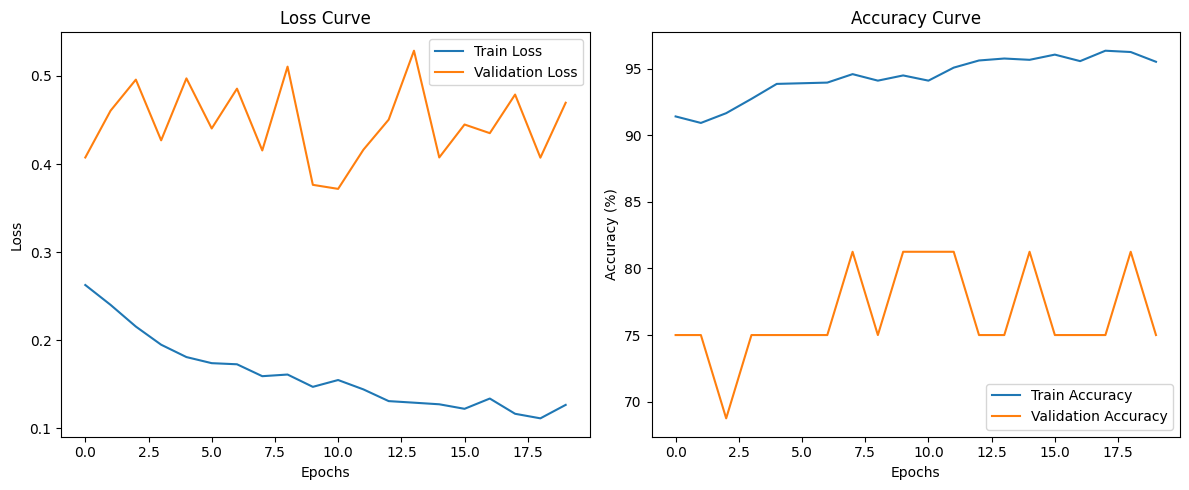

In [38]:
plt.figure(figsize=(12, 5))

# loss graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# show
plt.tight_layout()
plt.show()

# **Evaluate**

In [39]:
model_path = 'model.pth'
avg_test_loss, avg_test_acc = evaluate(model, device, model_path, test_loader, criterion)

<ipython-input-30-72acf586f4d8>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model weights loaded successfully.
Test Accuracy: 88.96%
Test Loss: 0.2879
